## Aggregation of multidop statistics onto RRM grid

This takes Ben Hillman's TWP grids and aggregates statistics of reflectivty and
vertical velocity onto said grids.

In [6]:
import pyart
from scipy import interpolate
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.collections import PatchCollection
from matplotlib import path
%matplotlib inline
import cartopy
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [7]:
twp_grid_path = '/home/rjackson/data/twp_grid/twpx4v1np4b_scrip_170613.nc'
twp_grid_latlon = '/home/rjackson/data/twp_grid/twpx4v1np4b_latlon_170613.nc'
example_multidop_file = '/home/rjackson/multidop_grids/cf_compliant_grid200511200300.nc'

twp_grid_dataset = Dataset(twp_grid_path)
latlon_dataset = Dataset(twp_grid_latlon)
multidop_grid = pyart.io.read_grid(example_multidop_file)
grid_corner_lon = twp_grid_dataset.variables['grid_corner_lon']
grid_corner_lat = twp_grid_dataset.variables['grid_corner_lat']
grid_center_lat = twp_grid_dataset.variables['grid_center_lat']
grid_center_lon = twp_grid_dataset.variables['grid_center_lon']
latlon_corners = latlon_dataset.variables['lon']
print(grid_corner_lat[1])

[-27.57470463 -27.8638928  -27.73518826 -27.59618244 -27.42456485
 -27.42456485]


In [8]:
size = grid_corner_lon.shape
num_hexagons = size[0]

(-12.7, -12.0)

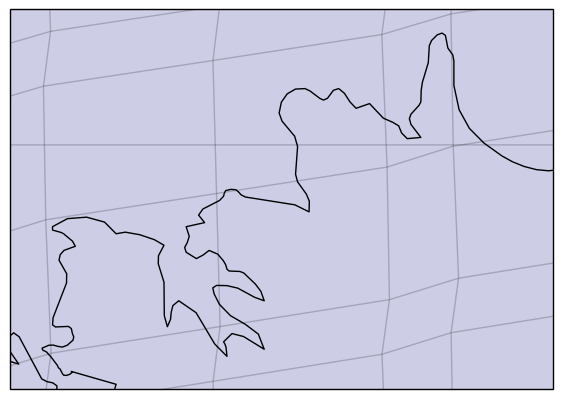

In [9]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())
hexagons = []
hexagon_paths = []

for i in range(0,num_hexagons):
    vertex_list = [[x,y] for (x,y) in zip(grid_corner_lon[i],grid_corner_lat[i])]
    hexagons.append(patches.Polygon(vertex_list, closed=True, fill=False))
p = PatchCollection(hexagons, alpha=0.1)
colors = 100*np.ones(num_hexagons)
p.set_array(colors)
ax.add_collection(p)
ax.coastlines(resolution='10m')
ax.set_xticks([-180, -90, 0, 90, 190], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())

plt.xlim((130.5, 131.5))
plt.ylim((-12.7, -12.0))

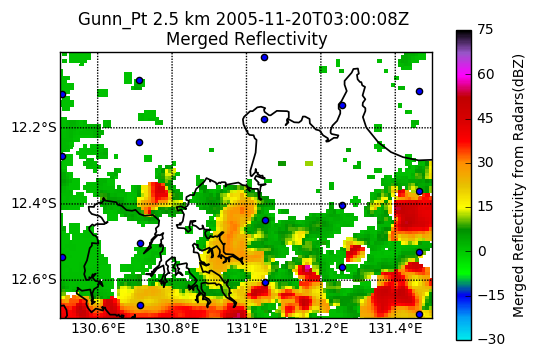

In [10]:
grid_display = pyart.graph.GridMapDisplay(multidop_grid)
grid_display.plot_basemap(min_lat=-12.7, max_lat=-12.0,
                          min_lon=130.5, max_lon=131.5,
                          auto_range=False,
                          lat_lines=[-12.8, -12.6, -12.4, -12.2, -12.0],
                          lon_lines=[130.4, 130.6, 130.8, 131.0, 131.2, 131.4, 131.6],
                          resolution='h')
grid_display.plot_grid('reflectivity', level=4)

# Get polygons whose centers are within Multidop domain
within_lats = np.logical_and(grid_center_lon[:] > 130.5,
                             grid_center_lon[:] < 131.5)
within_lons = np.logical_and(grid_center_lat[:] > -12.7,
                             grid_center_lat[:] < -12.0)
the_inds = np.where(np.logical_and(within_lats, within_lons))

rrm_grid_x, rrm_grid_y = grid_display.basemap(grid_center_lon[the_inds], 
                                              grid_center_lat[the_inds])
plt.scatter(rrm_grid_x, rrm_grid_y)

(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)
(2, 6)


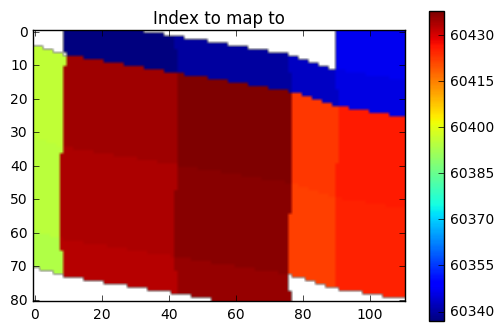

In [11]:
lons_grid, lats_grid = multidop_grid.get_point_longitude_latitude(level=0)
points = np.ma.zeros(lons_grid.shape)
zones = -99.0*np.ma.ones(lons_grid.shape)

for i in the_inds:
    vertex_list = [[x,y] for (x,y) in zip(grid_corner_lon[i],grid_corner_lat[i])]
    vertex_list = np.array(vertex_list)
vertex_list[:,:,5] = vertex_list[:,:,0]

for i in range(0,len(the_inds[0])):
    print(vertex_list[0].shape)
    the_path = path.Path(np.transpose(vertex_list[i]))
    for j in range(0,points.shape[0]):
        for k in range(0,points.shape[1]):
            if(the_path.contains_point((lons_grid[j,k], lats_grid[j,k])) == True):
                points[j,k] = the_inds[0][i]
                zones[j,k] = i
                
points = np.ma.masked_where(points == 0, points)
zones = np.ma.masked_where(zones == -99.0, zones)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(points, vmin=min(the_inds[0]), vmax=max(the_inds[0]))
plt.colorbar()
plt.title('Index to map to')

In [12]:
reflectivity = multidop_grid.fields['reflectivity']['data']
u = multidop_grid.fields['eastward_wind']['data']
v = multidop_grid.fields['northward_wind']['data']
w = multidop_grid.fields['upward_air_velocity']['data']

In [13]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

mean_ref = np.zeros((len(the_inds[0]),40))
five_ref = np.zeros((len(the_inds[0]),40))
ninety_five_ref = np.zeros((len(the_inds[0]),40))
ninety_ref = np.zeros((len(the_inds[0]),40))
ten_ref = np.zeros((len(the_inds[0]),40))
mean_w = np.zeros((len(the_inds[0]),40))
five_w = np.zeros((len(the_inds[0]),40))
ninety_five_w = np.zeros((len(the_inds[0]),40))
ninety_w = np.zeros((len(the_inds[0]),40))
ten_w = np.zeros((len(the_inds[0]),40))
for i in range(0,len(the_inds[0])):
    for j in range(0,40):
        ref_level = reflectivity[j]
        w_level = w[j]
        mean_ref[i,j] = np.nanmean(ref_level[np.where(zones == i)]) 
        five_ref[i,j] = np.nanpercentile(ref_level[np.where(zones == i)], 5)
        ninety_five_ref[i,j] = np.nanpercentile(ref_level[np.where(zones == i)], 95)
        ninety_ref[i,j] = np.nanpercentile(ref_level[np.where(zones == i)], 90)
        ten_ref[i,j] = np.nanpercentile(ref_level[np.where(zones == i)], 10)
        mean_w[i,j] = np.nanmean(w_level[np.where(zones == i)]) 
        five_w[i,j] = np.nanpercentile(w_level[np.where(zones == i)], 5)
        ninety_five_w[i,j] = np.nanpercentile(w_level[np.where(zones == i)], 95)
        ninety_w[i,j] = np.nanpercentile(w_level[np.where(zones == i)], 90)
        ten_w[i,j] = np.nanpercentile(w_level[np.where(zones == i)], 10)

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4185: Use